# Multi-Agent Collaboration Environment

## 1. Roll Call

This demo will show how remote agents can be discovered and participate in a multi-agent dialogue asynchronously without orchestration.

Start server1:
> python main.py --mode=node --persona=Sara

Start server2:
> python main.py --mode=node --persona=Diana

Start server3:
> python main.py --mode=node --persona=George


INFO     GaiNetNode.connect: Ready.
INFO     start rollcall
DEBUG    mace_client.rollcall_handler: {'Name': 'George', 'ClassName': 'Assistant', 'AgentDescription': 'Hi there! I am an Assistant class generative AI agent.', 'AgentShortDesc': None, 'Image64': '...', 'Image128': '...'}
DEBUG    mace_client.rollcall_handler: George
DEBUG    mace_client.rollcall_handler: {'Name': 'Diana', 'ClassName': 'Assistant', 'AgentDescription': 'Hi there! I am an Assistant class generative AI agent.', 'AgentShortDesc': None, 'Image64': '...', 'Image128': '...'}
DEBUG    mace_client.rollcall_handler: Diana
INFO     George:Hi there! I am an Assistant class generative AI agent.
INFO     Diana:Hi there! I am an Assistant class generative AI agent.


George


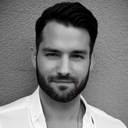

Diana


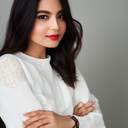

In [1]:
from gai.mace.user.mace_client import MaceClient
from gai.lib.common.logging import getLogger
logger = getLogger(__name__)
user = await MaceClient.create(servers="nats://nats01:4222")
await user.subscribe()
await user.rollcall()

import base64
import json
from IPython.display import Image, display
for msg in user.rollcall_messages:
    data=json.loads(msg["data"])
    name=data["Name"]
    short_desc=data["AgentShortDesc"]
    long_desc=data["AgentDescription"]
    class_name=data["ClassName"]
    image_base64=data["Image128"]
    image_binary = base64.b64decode(image_base64)
    print(name)
    display(Image(data=image_binary))

---
## 2. Dialogue

This demo will show two examples of how to orchestrate a multi-agent dialogue asynchronously using a sequence diagram.

### 2a) Connecting to MACE and Setting up the UI


In [2]:
# Start a connection

from gai.mace.user.mace_client import MaceClient
from gai.lib.common.logging import getLogger
logger = getLogger(__name__)
user = await MaceClient.create(servers="nats://nats01:4222")
await user.clear_dialogue()

# Register a callback

from IPython.display import display, Markdown, clear_output
from nats.aio.msg import Msg
import json
from gai.mace.pydantic.FlowMessagePydantic import FlowMessagePydantic
from gai.lib.dialogue.dialogue_store import DialogueStore

displayed_output=None
sara_text=""
diana_text=""
george_text=""

async def on_chat(msg: Msg):
    global displayed_output,sara_text,diana_text,george_text
    data = msg.data.decode()
    data = json.loads(data)
    pydantic = FlowMessagePydantic(**data)

    # The following code is used mainly for formatting the data for display in notebook.

    if pydantic.Chunk == "\n":
        pydantic.Chunk = "<br>"

    if pydantic.Chunk:
        if pydantic.Sender == "Sara":
            sara_text+=pydantic.Chunk
        if pydantic.Sender == "Diana":
            diana_text+=pydantic.Chunk
        if pydantic.Sender == "George":
            george_text+=pydantic.Chunk
    
    if pydantic.ChunkNo == "<eom>":
        if pydantic.Sender == "Sara":
            sara_text+="<br><br>"
        if pydantic.Sender == "Diana":
            diana_text+="<br><br>"
        if pydantic.Sender == "George":
            george_text+="<br><br>"

        # Save dialogue
        content=""
        content=user._strip_xml(content)
        message_id=DialogueStore.create_message_id(pydantic.DialogueId,pydantic.RoundNo,pydantic.TurnNo,"B")
        MaceClient.dialogue_store.add_assistant_message(message_id=message_id,name=pydantic.Sender, content=content)


    # Clear previous output and update with new data
    clear_output(wait=True)
    displayed_output.update(Markdown(f"|Sara|Diana|George|\n|---|---|---|\n| {sara_text} | {diana_text} | {george_text} |\n"))

def show():
    global displayed_output, sara_text, diana_text, george_text
    displayed_output = display(Markdown(""), display_id=True)
    sara_text=""
    diana_text=""
    george_text=""


INFO     GaiNetNode.connect: Ready.


### 2b) Polling

User will send the same message to each agents in a round-robin way. For example, self-introductions. The instruction to every agent is the same, ie. introduce yourself.

```mermaid
sequenceDiagram
        User->>Sara: null
        User->>Diana: null
        User->>Christine: null
```

In [ ]:

show()
await user.subscribe(async_chat_handler=on_chat)
step=await user.dialogue(msg="Introduce yourself.")
while step:
    step=await user.next()

|Sara|Diana|George|
|---|---|---|
| <Sara> |  |  |


INFO     start rollcall
INFO     Sara:Hello, I am Sara, your trusty assistant. I'm here to ensure your day runs smoothly and all your tasks are completed with precision. With my meticulous nature, I will leave no stone unturned in delivering the most accurate results. Additionally, my helpful demeanor will always guide you towards the best solutions.

INFO     
User:
Introduce yourself.


In [ ]:
print(user.dialogue_state["flow_diagram"])
user.dialogue_store.list_dialogue_messages()

User->>George
User->>Diana
User->>Sara



[DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:2:1B', DialogueId='00000000-0000-0000-0000-000000000000', Order=6, OwnerId=None, Role='assistant', Name='Sara', Content='', Monologue=None, Timestamp=1730613279, ImageUrl='http://localhost:12033/api/v1/persona/Sara/thumbnail'),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:2:2B', DialogueId='00000000-0000-0000-0000-000000000000', Order=7, OwnerId=None, Role='assistant', Name='George', Content='', Monologue=None, Timestamp=1730613283, ImageUrl='http://localhost:12033/api/v1/persona/George/thumbnail'),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:3:0A', DialogueId='00000000-0000-0000-0000-000000000000', Order=8, OwnerId='00000000-0000-0000-0000-000000000000', Role='user', Name='user', Content='Help me plan a trip to Greece.', Monologue=None, Timestamp=1730613336, ImageUrl=None),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:3:0B', DialogueId='00000000-0000-0000-0

### 3b) Pipelining

User only send message to the first agent and subsequent agents will build upon the response. For example, story telling. Story telling involved the next agent building upon the story started by the previous agent.

```mermaid
sequenceDiagram
        User->>Sara: null
        Sara->>Diana: null
        Diana->>Christine: null
```


In [20]:
show()
seq_diagram = """
    sequenceDiagram
        User->>Sara
        Sara->>Diana
        Diana->>George
"""
step=await user.dialogue(msg="Help me plan a trip to Greece.",flow_diagram=seq_diagram)
while step:
    step=await user.next()

|Sara|Diana|George|
|---|---|---|
| <Sara>Of course, I'd be happy to help you plan a trip to Greece. Let's start with some basic information. When are you planning to travel? Are you looking for a solo trip, or will there be others joining you? What are your interests and preferences during your travels? For example, do you prefer sightseeing, adventure activities, relaxing on the beach, or trying local cuisine? This information will help me provide a more personalized plan for your trip.</Sara><br><br> | <Diana>Yes, my turn to be the Devil's Advocate has indeed arrived. Looking at the user's request for help in planning a trip to Greece, I feel compelled to point out a potential flaw in their plans. It seems they may be overlooking the importance of understanding the customs and traditions of the country they are visiting. It’s essential to respect cultural differences to create a positive experience for everyone involved. Not being aware of these could lead to misunderstandings or even faux pas which could ruin the trip. So, I suggest that they spend some time researching not just the tourist attractions, but also the local culture and customs of Greece. This will certainly add depth to their travel plans and make their trip more enjoyable and enriching.</Diana><br><br> | <George>Hello! I'm an AI assistant. Based on your conversation, it seems like you're interested in planning a trip to Greece and need some information about it. I found a comprehensive Greece travel guide that includes topics such as popular activities, destinations, transportation, visa requirements, and money and costs. It covers a wide range of topics to help you plan your trip effectively. Would you like me to provide more specific information on any of these topics or assist you with something else?</George><br><br> |


In [5]:
print(user.dialogue_state["flow_diagram"])
user.dialogue_store.list_dialogue_messages()

User->>Sara
User->>Diana



[DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:1:0A', DialogueId='00000000-0000-0000-0000-000000000000', Order=0, OwnerId='00000000-0000-0000-0000-000000000000', Role='user', Name='user', Content='Introduce yourself.', Monologue=None, Timestamp=1730596913, ImageUrl=None),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:1:0B', DialogueId='00000000-0000-0000-0000-000000000000', Order=1, OwnerId=None, Role='assistant', Name='Sara', Content='', Monologue=None, Timestamp=1730596918, ImageUrl='http://localhost:12033/api/v1/persona/Sara/thumbnail'),
 DialogueMessagePydantic(Id='00000000-0000-0000-0000-000000000000:1:1B', DialogueId='00000000-0000-0000-0000-000000000000', Order=2, OwnerId=None, Role='assistant', Name='Diana', Content='', Monologue=None, Timestamp=1730596926, ImageUrl='http://localhost:12033/api/v1/persona/Diana/thumbnail')]

### 3c) Chat

Simply directing the message to any persona's name.

In [3]:
show()
message_id=await user.dialogue(msg="Diana, what do you think?")


INFO     start rollcall


AttributeError: 'NoneType' object has no attribute 'Dest'

In [7]:
show()
message_id=await user.dialogue(msg="George, please scour for other information that can be useful to us")


|Sara|Diana|George|
|---|---|---|
|  | <Diana> |  |


In [ ]:
show()
message_id=await user.dialogue(msg="Sara, please summarise our plan in markup")